# Alan Data

i.e. the big one.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from edges_cal import modelling as mdl
from pathlib import Path

import mcmc_utils as mutl
from edges_estimate.eor_models import AbsorptionProfile
from edges_estimate.fitting import SemiLinearFit
from getdist import plots

import alan_data_utils as utils
import alan_data as adata
import glob
import run_alan_data_mcmc as mcmc
from scipy import optimize
import notebook_utils as nutl
import pickle
from multiprocessing import Pool
from astropy import units as u
from edges_cal.modelling import LinLog
from yabf import run_map
from alan_data_utils import make_absorption
plt.ion()

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
nutl.setup_mpl()

In [3]:
runs = mutl.get_completed_mcsamples(mcmc.precal.FOLDER, include_incomplete=True)

outputs/alan_field_and_cal/c06_w05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsimFalse_fg10_simulTrue_taufxFalse_ns00_nd00_sd1234/bayescal.txt
Removed no burn in
outputs/alan_field_and_cal/c06_w05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsimFalse_fg5_simulTrue_taufxFalse_ns00_nd00_sd1234/bayescal.txt
Removed no burn in
outputs/alan_field_and_cal/c06_w05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsimFalse_fg9_simulTrue_taufxFalse_ns00_nd00_sd1234/bayescal.txt
Removed no burn in


In [4]:
isolated = mutl.get_completed_mcsamples('alan_field_isolated', include_incomplete=True)

In [5]:
lk = mcmc.precal.get_likelihood_from_label("c06_w05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsimFalse_fg4_simulTrue_taufxFalse_ns00_nd00_sd1234")

('open', 'short')


In [6]:
def get_eor_curves(mc):
    
    kw = mcmc.precal.get_kwargs(Path(mc.root).parent.name)
    
    # We have to get nparams this way because we might have constructed with a dodgy .paramnames file.
    lk = mcmc.precal.get_likelihood(**kw)
    pidx = [i for i, p in enumerate(lk.partial_linear_model.child_active_params) if p.name in ("A", "nu0", 'w', 'tau')]
    
    nparams = len(lk.partial_linear_model.child_active_params)

    equal_weight_samples = np.genfromtxt(mc.root + "_equal_weights.txt")[:, 2 : (2 + nparams)]
    
    eor = []
    for sample in equal_weight_samples:
        eor.append(lk.eor_components[0](params=sample[pidx])['eor_spectrum'])
        
    return np.array(eor)
    

In [7]:
eormodel = make_absorption(adata.sky_freq)

In [8]:


iso_eor_curves = {}
for name, mc in isolated.items():
    equal_weight_samples = np.genfromtxt(mc.root + "_equal_weights.txt")[:, 2 : 6]
    
    these = []
    for sample in equal_weight_samples:
        these.append(eormodel(params=sample)['eor_spectrum'])
        
    iso_eor_curves[name] = np.array(these)
        

In [9]:
eor_curves = {}
for name, mc in runs.items():
    eor_curves[name] = get_eor_curves(mc)

('open', 'short')
('open', 'short')
('open', 'short')
('open', 'short')
('open', 'short')
('open', 'short')
('open', 'short')


In [10]:
fiducial_fits = {}
for name, run in runs.items():
    kw = mcmc.precal.get_kwargs(name)
    
    fg = kw['nterms_fg']
    
    if fg in fiducial_fits:
        continue
        
    linlog = mdl.LinLog(n_terms=fg)
    
    # NOTE that this fit has constant variance with frequency!
    slf = SemiLinearFit(
        fg=linlog.at(x=adata.sky_freq), 
        eor=utils.make_absorption(adata.sky_freq),
        spectrum=adata.sky_temp, 
        sigma=0.03
    )
    fiducial_fits[fg] = (slf, slf(dual_annealing_kw={'maxiter':200}))

In [41]:
fiducial_fits_wvar[5]

(<edges_estimate.fitting.SemiLinearFit at 0x7f4443943ca0>,
      fun: -274.07774269927876
  message: ['Maximum number of iteration reached']
     nfev: 1876
     nhev: 0
      nit: 200
     njev: 55
   status: 0
  success: True
        x: array([ 0.62033368, 78.10724806,  5.7532107 , 18.95317791]))

In [60]:
fiducial_fits_wvar = {}
for name, run in runs.items():
    kw = mcmc.precal.get_kwargs(name)
    
    fg = kw['nterms_fg']
    
    if fg in fiducial_fits_wvar:
        continue
        
    linlog = mdl.LinLog(n_terms=fg)
    
    lknew = utils.get_isolated_likelihood(
        labcal32, 
        calobs32,
        fsky=adata.sky_data['freq'],
        fg=linlog, 
        eor=utils.make_absorption(adata.sky_data['freq']),
        ml_solution='outputs/alan_cal/c06_w05_cf06_wf05_smooth32_tns0500_ign[()]_sim[(\'open\', \'short\')]_s11()_antsim-False/bayescal.map',
        mcdef=cal.mcdef
    )
    
    res = run_map(lknew.partial_linear_model, dual_annealing_kw={'maxiter':200})
    fiducial_fits_wvar[fg] = (lknew, res)

[autoreload of run_alan_data_mcmc failed: Traceback (most recent call last):
  File "/home/smurray/miniconda3/envs/edges/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/smurray/miniconda3/envs/edges/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/smurray/miniconda3/envs/edges/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/smurray/miniconda3/envs/edges/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 855, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/data4/smurray/Projects/radio/EOR/Edges/bayesian-calibration/run_alan_data_mcmc.py", line 57, in <module>
    **

AttributeError: module 'run_alan_precal_mcmc' has no attribute 'get_kwargs'

In [46]:
calobs32 = utils.get_calobs(smooth=32)
labcal32 = utils.get_labcal(calobs32)

In [54]:
fiducial_fits_recal = {}
for name, run in runs.items():
    kw = mcmc.precal.get_kwargs(name)
    lk = mcmc.precal.get_likelihood(**kw)
    
    fg = kw['nterms_fg']
    
    if fg in fiducial_fits_recal:
        continue
        
    linlog = mdl.LinLog(n_terms=fg)
    recal_tsky = utils.recalibrate(labcal32, t_sky=adata.sky_data["t_ant"], f_sky=adata.sky_freq) 
    
    best = run.samples[np.argmax(-run.loglikes)][:len(lk.partial_linear_model.child_active_params)]
    # tns = lk.partial_linear_model.get_ctx(params=best)['tns_field']
    tns = calobs32.C1(adata.sky_freq*u.MHz) * 1000
    variance = lk.partial_linear_model.data['data_variance']['ant'] * tns**2
    slf = SemiLinearFit(
        fg=linlog.at(x=adata.sky_freq), 
        eor=utils.make_absorption(adata.sky_freq),
        spectrum=recal_tsky, 
        sigma=np.sqrt(variance)
    )
    fiducial_fits_recal[fg] = (slf, slf(dual_annealing_kw={'maxiter':200}))



('open', 'short')
('open', 'short')
('open', 'short')
('open', 'short')
('open', 'short')
('open', 'short')
('open', 'short')


In [29]:
import matplotlib as mpl

In [55]:
mpl.rcParams['hatch.linewidth'] = 0.7  # previous pdf hatch linewidth
#mpl.rcParams['hatch.linewidth'] = 1.0  # previous svg hatch linewidth

In [56]:
def plot_inferred_absorption(use='mean', plot_regions=True):
    
    fig, ax = plt.subplots(len(runs)//3 + (len(runs) % 3 > 0), 3, sharex=True, sharey=True, figsize=(nutl.double_width, 0.75*nutl.double_width))
    
    for irun, name in enumerate(sorted(runs.keys(), key=lambda key: mcmc.precal.get_kwargs(key)['nterms_fg'])):
        mc = runs[name]
        kw = mcmc.precal.get_kwargs(Path(mc.root).parent.name)
        lk = mcmc.precal.get_likelihood(**kw)
        nparams = len(lk.partial_linear_model.child_active_params)

        pidx = [i for i, p in enumerate(lk.partial_linear_model.child_active_params) if p.name in ("A", "nu0", 'w', 'tau')]
        
        if use in ('mean', 'ml'):
            
            if use == 'mean':
                best = mc.getMeans()[pidx]
            elif use == 'ml':
                best = mc.samples[np.argmax(-mc.loglikes)][pidx]
   
            eor = lk.eor_components[0](params=best)['eor_spectrum']
        elif use == 'median':
            eor = np.median(eor_curves[name], axis=0)
            
        iso = iso_eor_curves[f"c06_w05_smooth32_fg{kw['nterms_fg']}_taufxFalse"]
        if plot_regions:
            p = np.percentile(eor_curves[name], (2.5, 16, 84, 97.5), axis=0)
         
            ax.flatten()[irun].fill_between(adata.sky_freq, p[0], p[-1], alpha=0.2, color=f"C{irun}", lw=0)
            ax.flatten()[irun].fill_between(adata.sky_freq, p[1], p[-2], alpha=0.4, color=f"C{irun}", lw=0)
            
            p = np.percentile(iso, (2.5, 16, 84, 97.5), axis=0)
            
            ax.flatten()[irun].fill_between(adata.sky_freq, p[0], p[-1], facecolor=f"none", lw=0, hatch='//////////',edgecolor="darkgrey", )
            ax.flatten()[irun].fill_between(adata.sky_freq, p[1], p[-2], facecolor=f"none", lw=0, hatch='\\\\\\\\\\\\\\\\\\\\', edgecolor="darkgrey")
            
        ax.flatten()[irun].plot(adata.sky_freq, eor, color=f"C{irun}", label='Simultaneous')
        ax.flatten()[irun].set_title(r"$N_{\rm FG}=%s$"%kw['nterms_fg'])
        
        
        slf, res = fiducial_fits_recal[kw['nterms_fg']]
        ax.flatten()[irun].plot(adata.sky_freq, slf.get_eor(res.x), color='k', ls='--', label='Isolated ML')

        # The 'non-weighted' fits all match the weighted ones, soo no point plotting them here.
        # slf, res = fiducial_fits[kw['nterms_fg']]
        # ax.flatten()[irun].plot(adata.sky_freq, slf.get_eor(res.x), color='k', ls=':', label='Isolated ML unw')

        ax.flatten()[irun].plot(adata.sky_freq, np.median(iso, axis=0), color=f'darkgrey', ls='--', label='Isolated MCMC')
        
    for axx in ax.flatten()[(irun+1):]:
        axx.axis('off')
        
    ax[0,0].legend()
    ax[-1, 0].set_xlabel("Frequency [MHz]")
    ax[-1, 1].set_xlabel("Frequency [MHz]")
    fig.supylabel(r"$\hat{T}_{21}$ [K]")
    #plt.legend()

In [58]:
fiducial_fits_recal[5]

(<edges_estimate.fitting.SemiLinearFit at 0x7f4480579cd0>,
      fun: -258.4619324446755
  message: ['Maximum number of iteration reached']
     nfev: 1726
     nhev: 0
      nit: 200
     njev: 25
   status: 0
  success: True
        x: array([ 0.60931221, 78.2990475 ,  5.32130938, 18.76250956]))

('open', 'short')
('open', 'short')
('open', 'short')
('open', 'short')
('open', 'short')
('open', 'short')
('open', 'short')


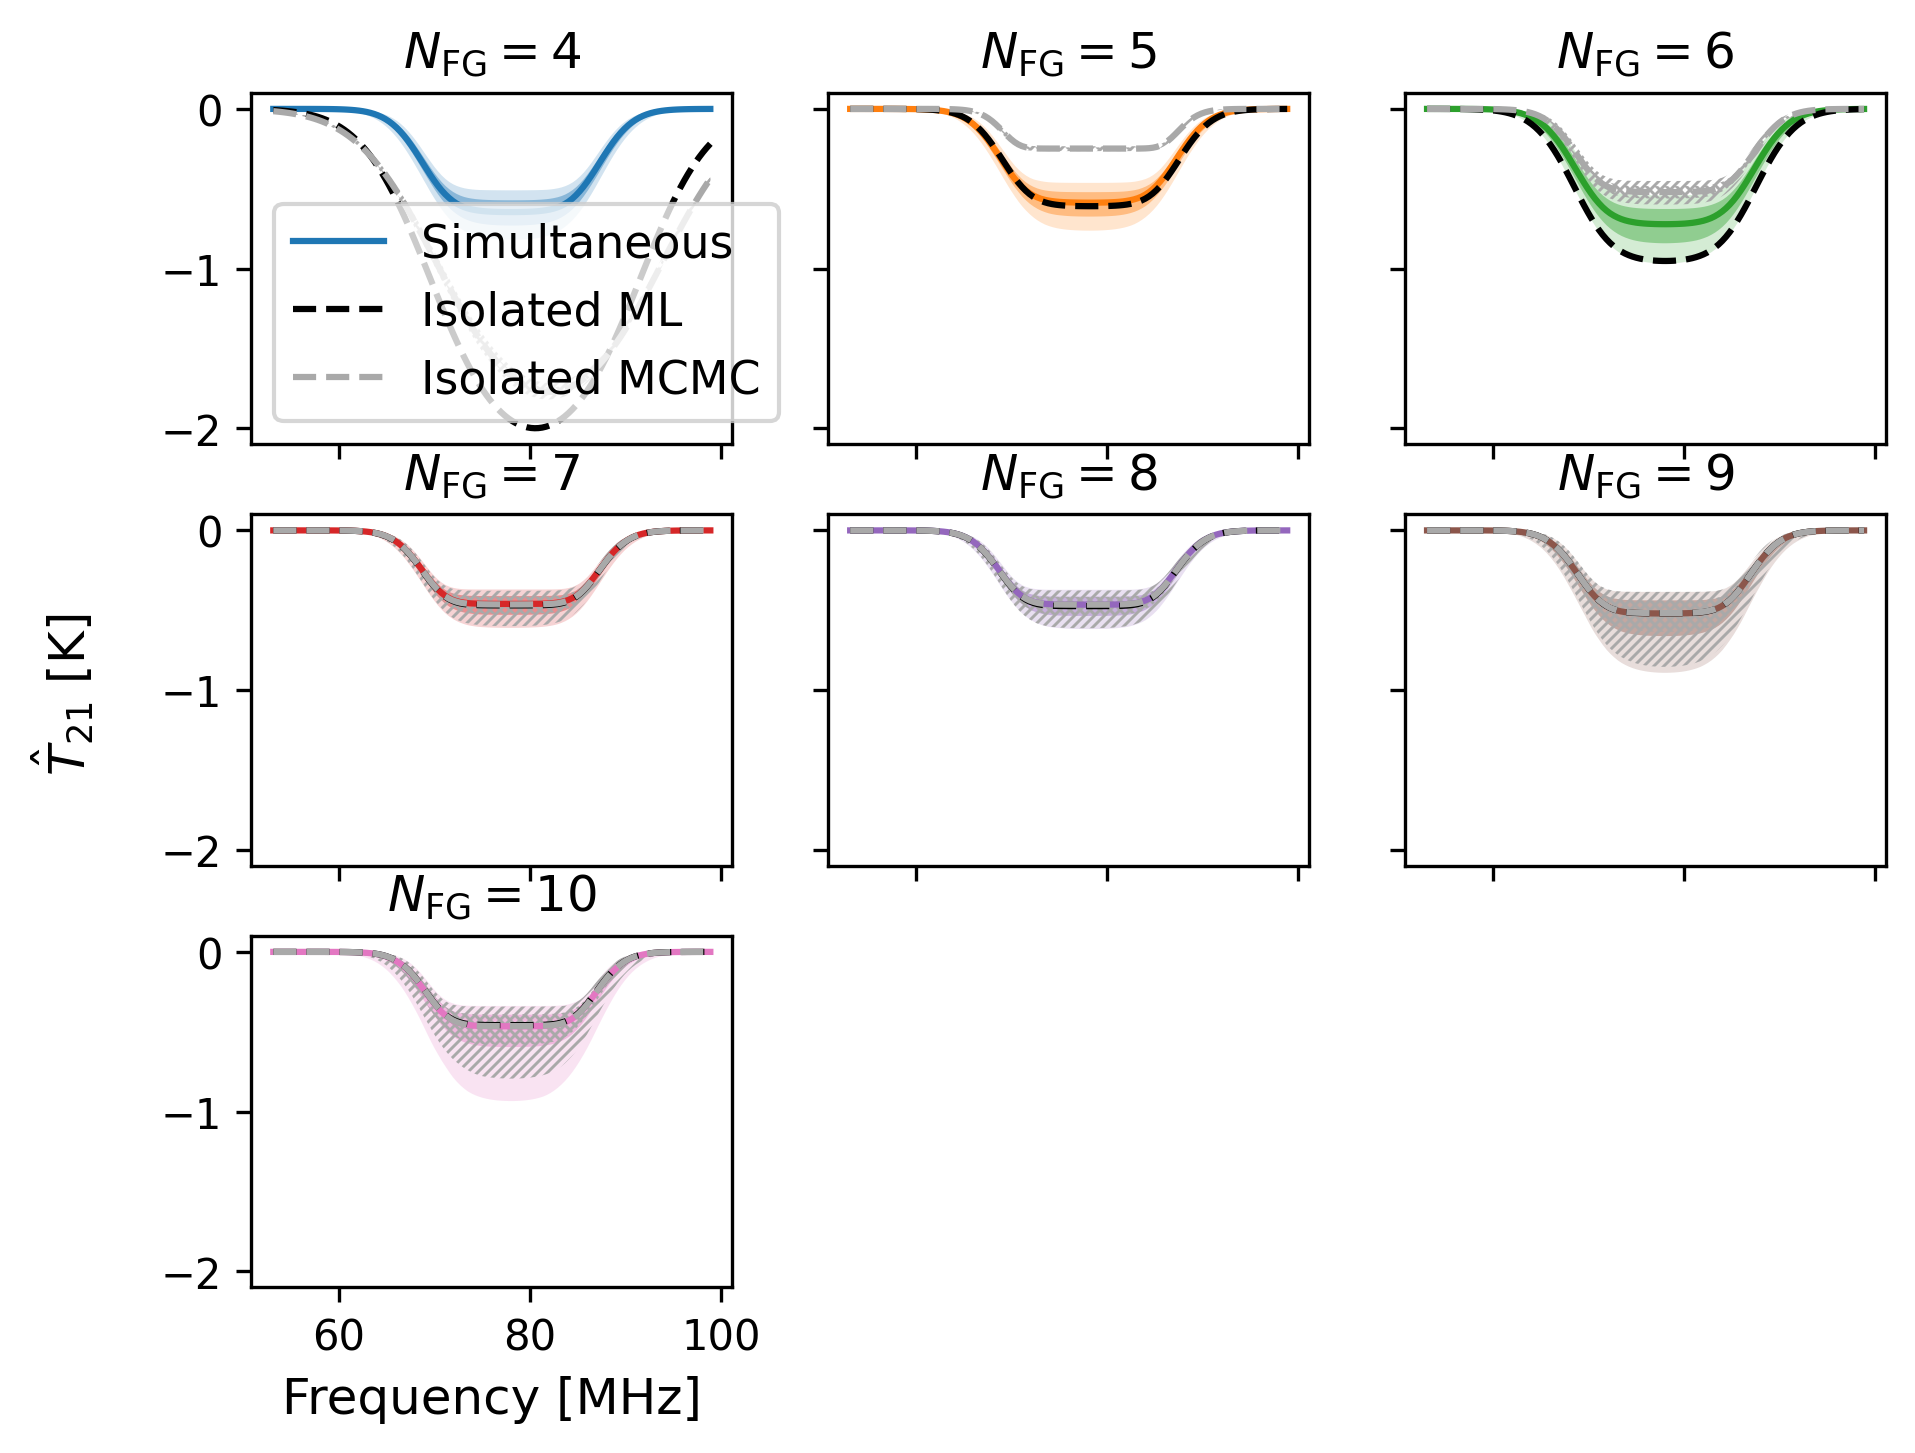

In [57]:
plot_inferred_absorption('median')

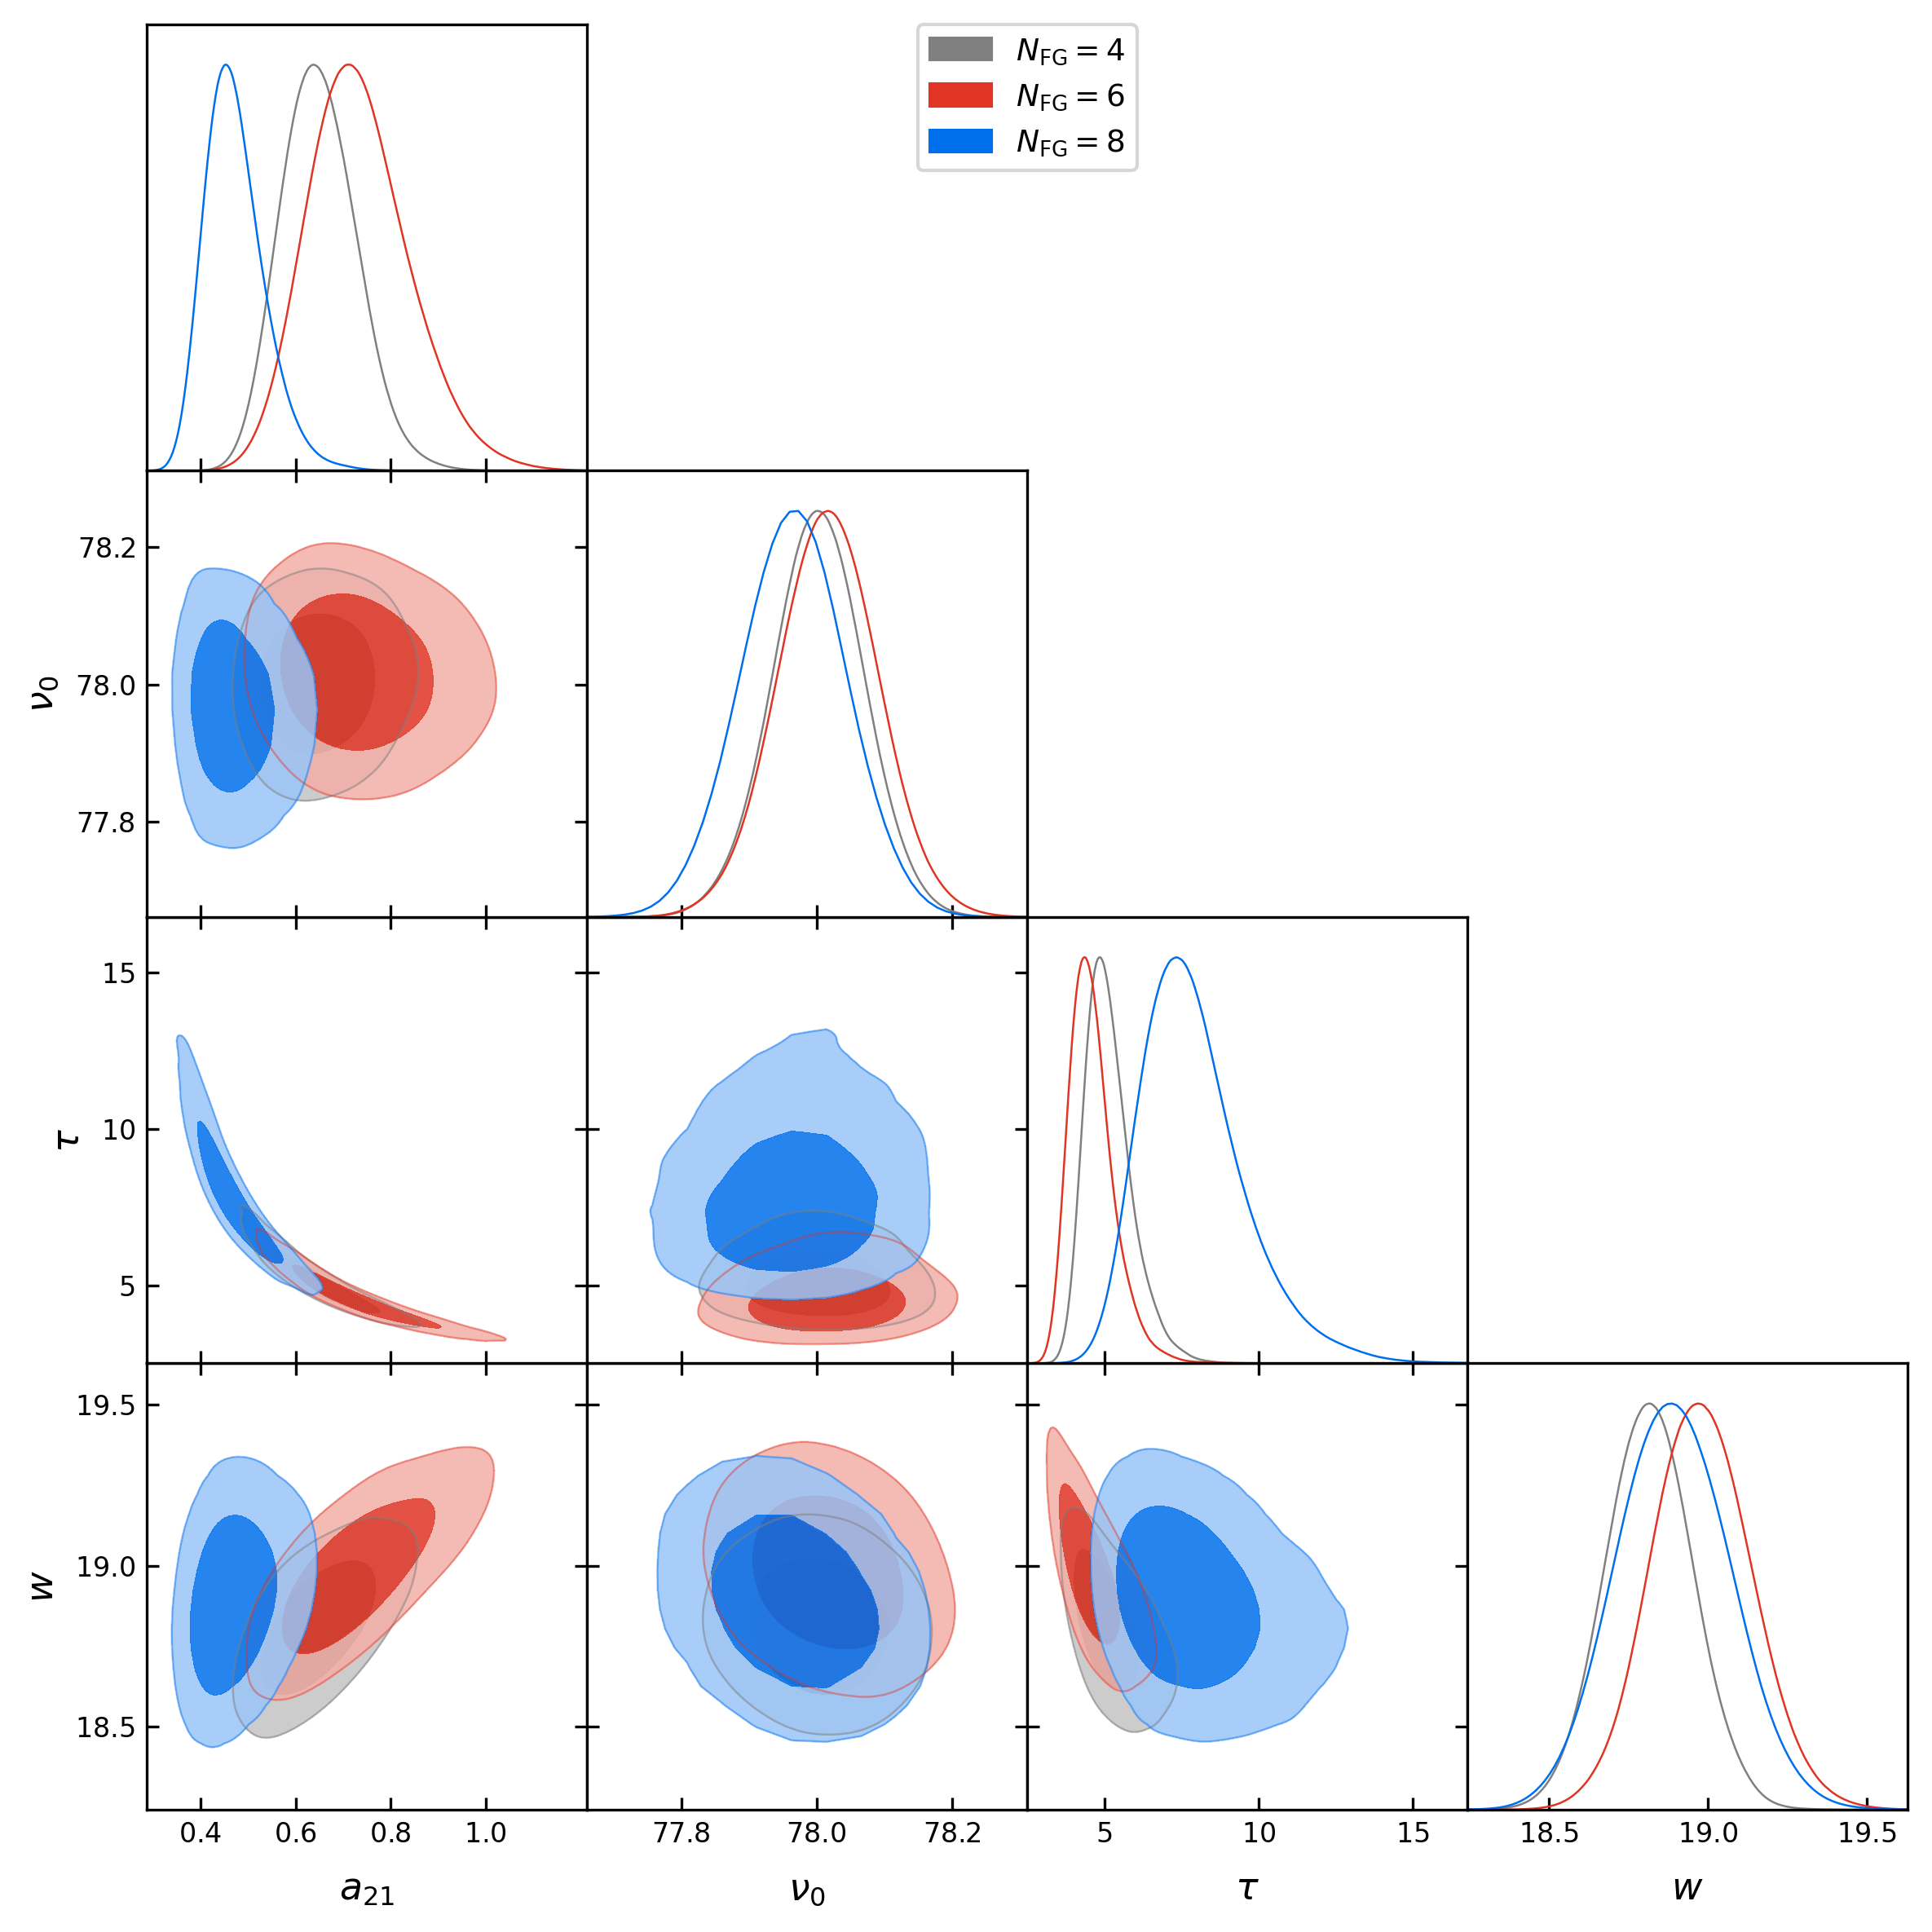

In [88]:
g = plots.get_subplot_plotter()
g.triangle_plot(
    [
        runs['c06_w05_smooth32_tns0500_ign[()]_sim[(\'open\', \'short\')]_s11()_antsimFalse_fg4_simulTrue_taufxFalse_ns00_nd00_sd1234'],
        runs['c06_w05_smooth32_tns0500_ign[()]_sim[(\'open\', \'short\')]_s11()_antsimFalse_fg6_simulTrue_taufxFalse_ns00_nd00_sd1234'],
        runs['c06_w05_smooth32_tns0500_ign[()]_sim[(\'open\', \'short\')]_s11()_antsimFalse_fg8_simulTrue_taufxFalse_ns00_nd00_sd1234'],
    ], 
    filled=True,
    legend_labels=[
        r'$N_{\rm FG}=4$',
        r'$N_{\rm FG}=6$',
        r'$N_{\rm FG}=8$',
    ],
    params=('A', 'nu0', 'tau', 'w')
)

In [92]:
calobs32 = utils.get_calobs(smooth=32)

[autoreload of run_alan_precal_mcmc failed: Traceback (most recent call last):
  File "/home/smurray/miniconda3/envs/edges/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/smurray/miniconda3/envs/edges/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/smurray/miniconda3/envs/edges/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/smurray/miniconda3/envs/edges/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 855, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/data4/smurray/Projects/radio/EOR/Edges/bayesian-calibration/run_alan_precal_mcmc.py", line 5, in <module>
   

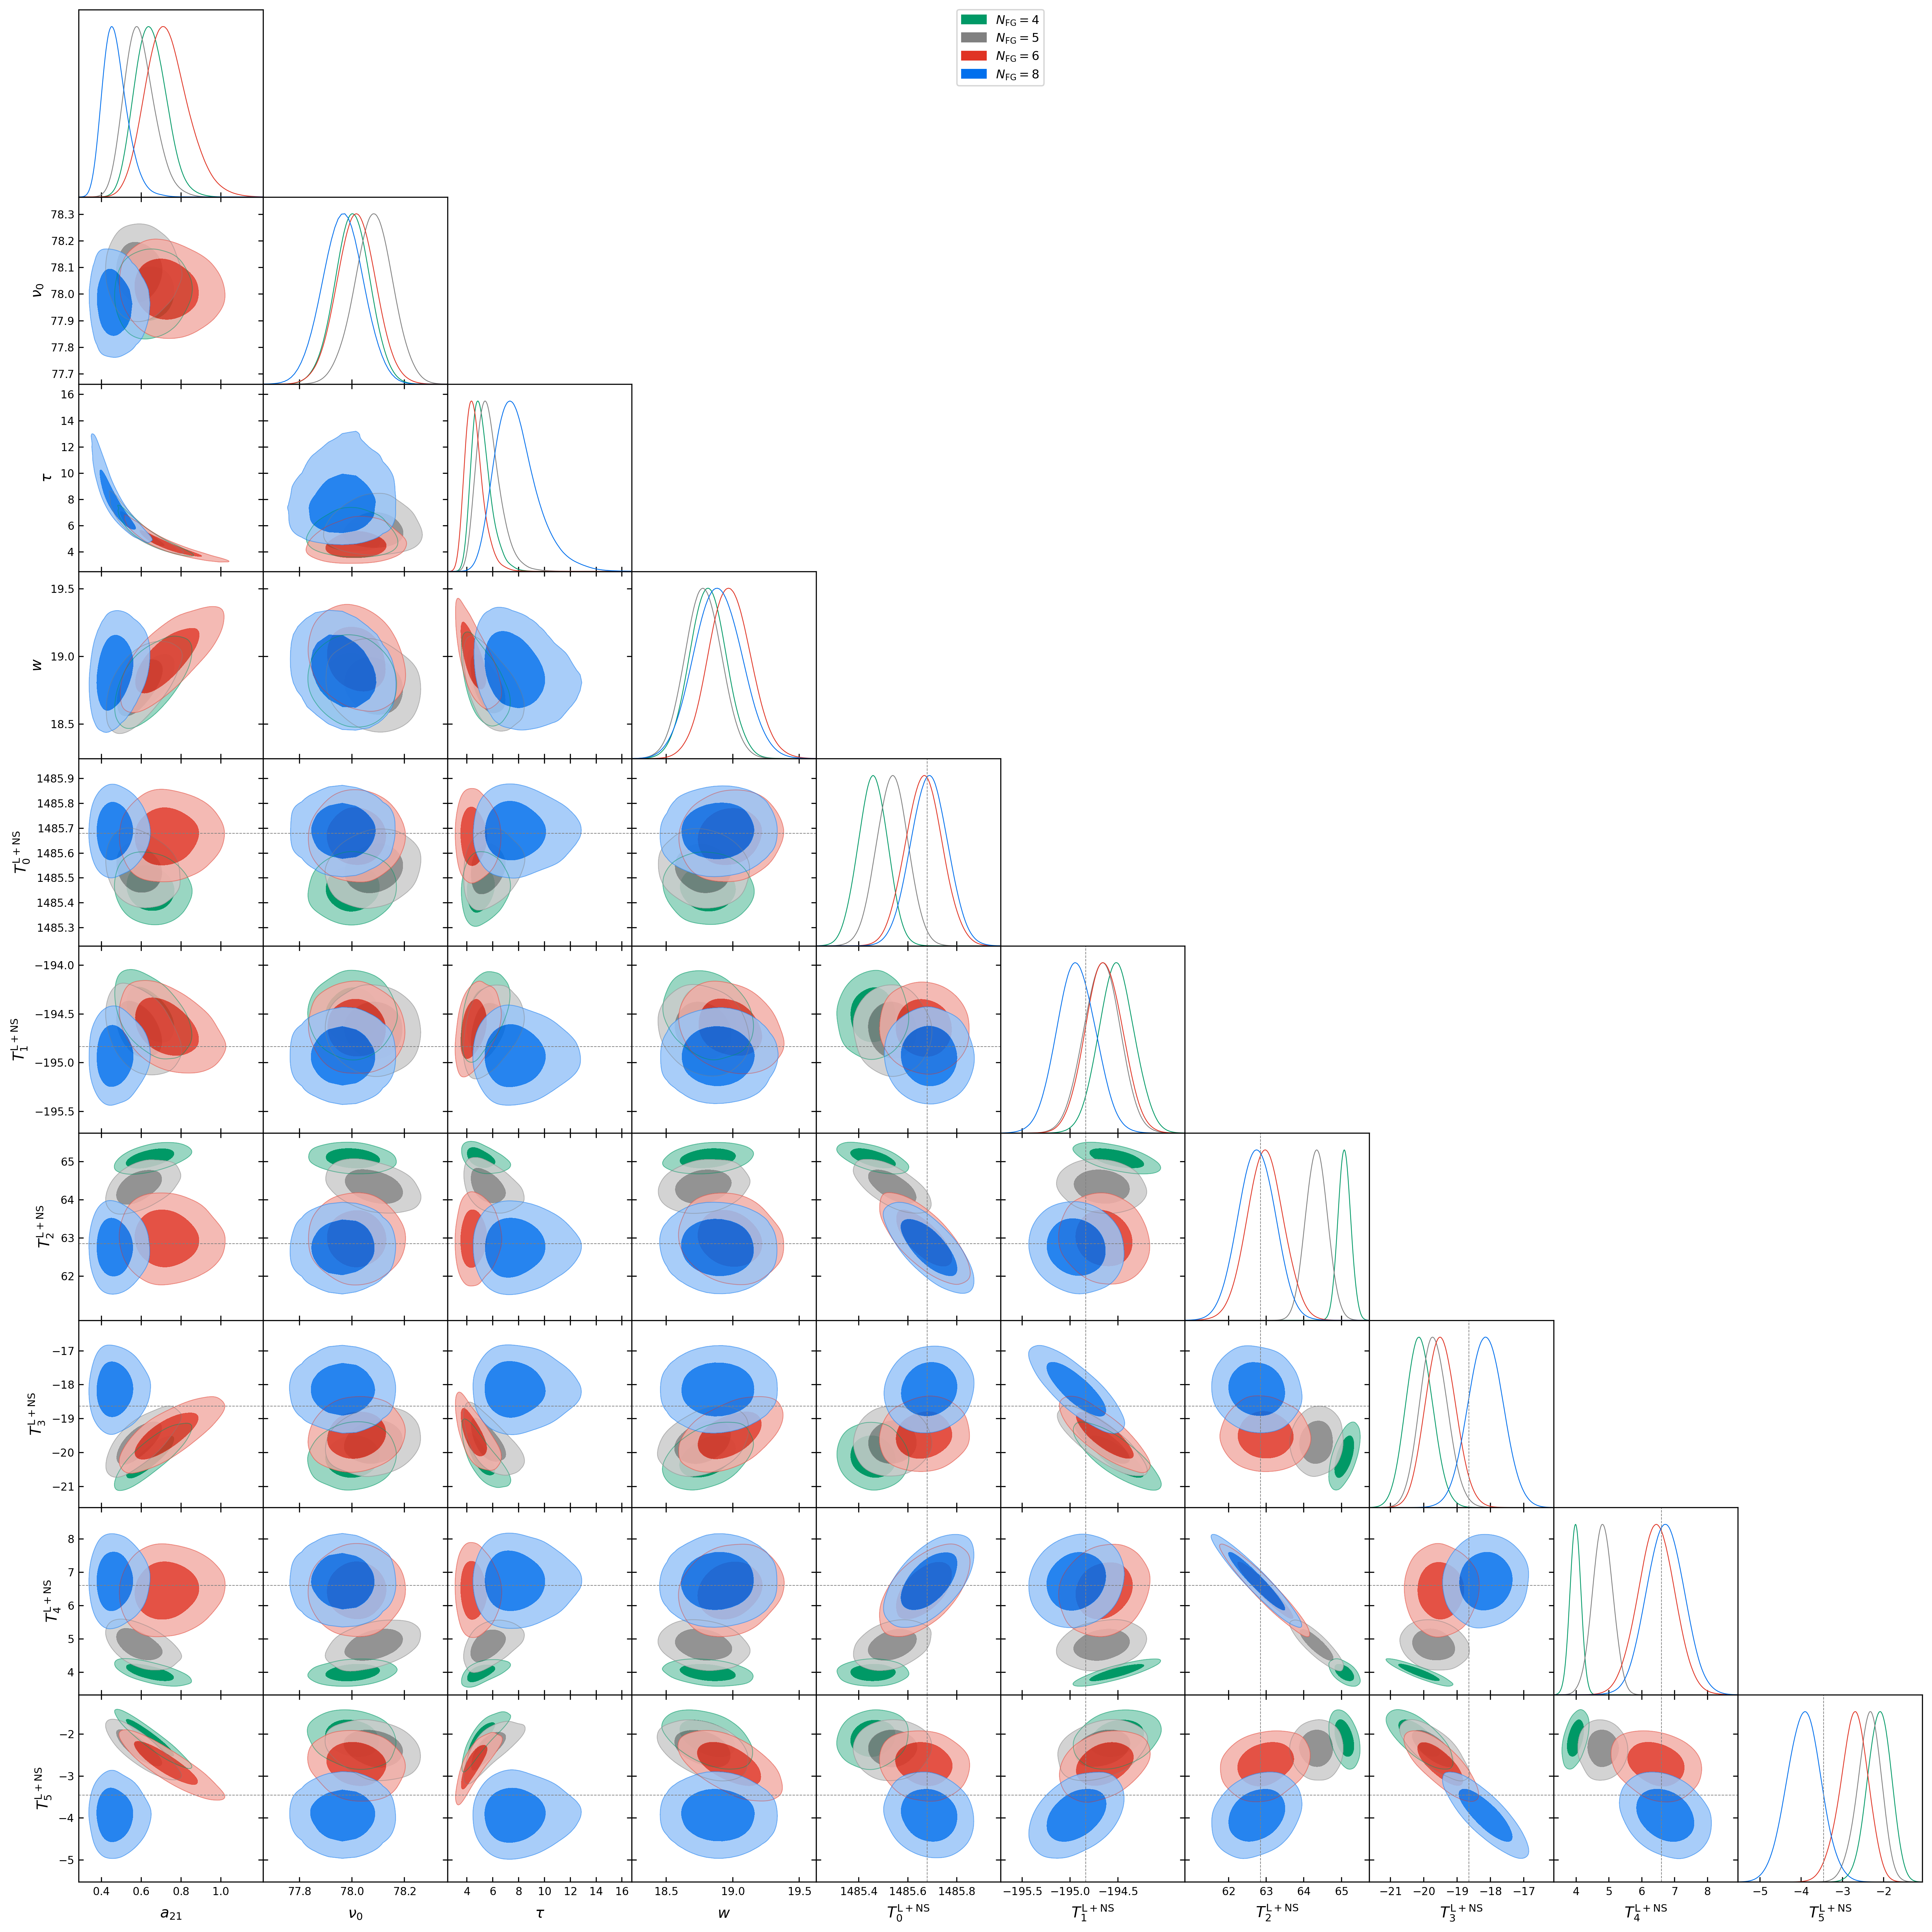

In [59]:
g = plots.get_subplot_plotter()
g.triangle_plot(
    [
        runs['c06_w05_smooth32_tns0500_ign[()]_sim[(\'open\', \'short\')]_s11()_antsimFalse_fg4_simulTrue_taufxFalse_ns00_nd00_sd1234'],
        runs['c06_w05_smooth32_tns0500_ign[()]_sim[(\'open\', \'short\')]_s11()_antsimFalse_fg5_simulTrue_taufxFalse_ns00_nd00_sd1234'],
        runs['c06_w05_smooth32_tns0500_ign[()]_sim[(\'open\', \'short\')]_s11()_antsimFalse_fg6_simulTrue_taufxFalse_ns00_nd00_sd1234'],
        runs['c06_w05_smooth32_tns0500_ign[()]_sim[(\'open\', \'short\')]_s11()_antsimFalse_fg8_simulTrue_taufxFalse_ns00_nd00_sd1234'],
    ], 
    filled=True,
    legend_labels=[
        r'$N_{\rm FG}=4$',
        r'$N_{\rm FG}=5$',
        r'$N_{\rm FG}=6$',
        r'$N_{\rm FG}=8$',
    ],
    params=('A', 'nu0', 'tau', 'w', 't_lns_0', 't_lns_1', 't_lns_2', 't_lns_3', 't_lns_4', 't_lns_5'),
    markers={f't_lns_{i}': 1000*c for i, c in enumerate(calobs32.C1_poly.coefficients[::-1])}
)

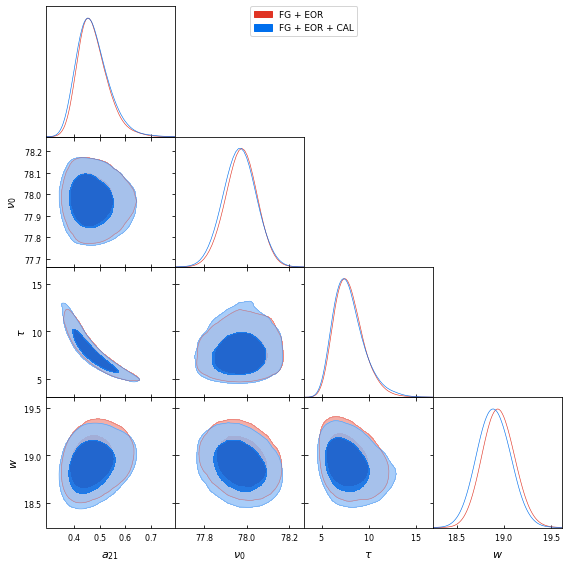

In [18]:
g = plots.get_subplot_plotter()
g.triangle_plot(
    [
        isolated['c06_w05_smooth32_fg8_taufxFalse'],
        runs['c06_w05_smooth32_tns0500_ign[()]_sim[(\'open\', \'short\')]_s11()_antsimFalse_fg8_simulTrue_taufxFalse_ns00_nd00_sd1234'],
    ], 
    filled=True,
    legend_labels=[
        'FG + EOR',
        'FG + EOR + CAL'
    ],
    params=('A', 'nu0', 'tau', 'w',),
#    markers={f't_lns_{i}': 1000*c for i, c in enumerate(calobs32.C1_poly.coefficients[::-1])}
)